In [1]:
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy.fft import fft,ifft
import sys
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\cGAN_subsampling\Functions')
from Metrics import ownPhaseMetricCorrected_numpy, ssimMetric, ownPhaseMetric_numpy
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.activations import gelu
from tensorflow.keras.layers import Activation

def dbscale(darray):
    if len(np.shape(darray))==3:
        img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)
    else:
        img = 10*np.log10(abs(darray[:,:])**2)
    return img

def logScale(slices):
    
    logslices = np.copy(slices)
    nSlices = slices.shape[2]
    logslicesAmp = abs(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # and retrieve the phase
    logslicesPhase = np.angle(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # reescale amplitude
    logslicesAmp = np.log10(logslicesAmp)
    slicesMax = np.reshape(logslicesAmp.max(axis=(0, 1)), ( 1, 1,nSlices))
    slicesMin = np.reshape(logslicesAmp.min(axis=(0, 1)), ( 1, 1,nSlices))
    logslicesAmp = (logslicesAmp - slicesMin) / (slicesMax - slicesMin)
    # --- here, we could even normalize each slice to 0-1, keeping the original
    # --- limits to rescale after the network processes
    # and redefine the real and imaginary components with the new amplitude and
    # same phase
    logslices[:, :, :, 0] = (np.real(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    logslices[:, :, :, 1] = (np.imag(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    
    return logslices, slicesMax, slicesMin

def inverseLogScale(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesPhase = np.angle(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def inverseLogScaleSummary(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesPhase = np.angle(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

def max_value(array):
    max_val = array[0]  # initialize maximum value as the first element of the array
    max_pos = 0         # initialize maximum position as 0
    for i in range(1, len(array)):
        if array[i] > max_val:
            max_val = array[i]  # update maximum value
            max_pos = i         # update maximum position
    return max_val, max_pos

def min_value(array):
    min_val = array[0]  # initialize maximum value as the first element of the array
    min_pos = 0         # initialize maximum position as 0
    for i in range(1, len(array)):
        if array[i] < min_val:
            min_val = array[i]  # update maximum value
            min_pos = i         # update maximum position
    return min_val, min_pos

def custom_gelu(x):
    return gelu(x, approximate=True)

In [17]:
dataPath = r'E:\DLOCT\Experimental_Data_complex'
tom = np.load(os.path.join(dataPath,'depthNail.npy'))
iff=ifft(tom[:,:,:,0]+1j*tom[:,:,:,1],axis=0)
tomcc = fft(abs(iff)*np.cos(np.angle(iff)),axis=0)
tomcc = 2*np.stack((tomcc.real,tomcc.imag),axis=3)
tomNorm,tmax,tmin = logScale(tom)
tomNorm = np.transpose(tomNorm, (2, 0, 1, 3))
tomccNorm,imax,imin = logScale(tomcc)
tomccNorm = np.transpose(tomccNorm, (2, 0, 1, 3))
print('tomograms loaded')

tomograms loaded


In [18]:
# print(tom[0,0,0,0])
print(np.max(tom))
print(np.max(tomcc))

6741804.5
6763023.736328125


In [19]:
modelsPath = r'E:\models\cxpix2pixcomplexdbscale3\models'
listmodels = os.listdir(modelsPath)
model = listmodels[-11]
model_loaded = tf.keras.models.load_model(os.path.join(modelsPath,model), 
                                            compile=False)
tomPredict = np.array(model_loaded.predict(tomccNorm, batch_size=1), dtype='float32')
gc.collect()
K.clear_session()
tomPredictreordered = np.transpose(tomPredict, (1, 2, 0, 3))
tomPredictFullScale = inverseLogScale(tomPredictreordered,imax,imin)

10/10 [==============================] - 17s 2s/step


Text(0.5, 1.0, 'Target')

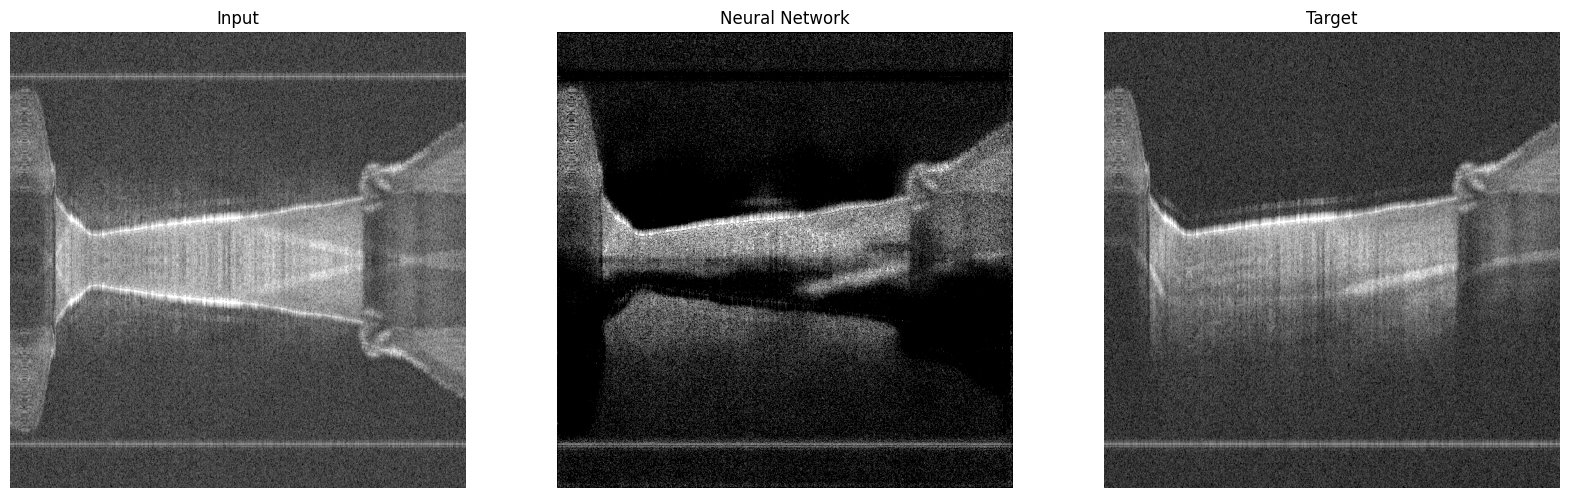

In [23]:
vmax = 120
vmin = 65
bscan = 0
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(20,15))
axs[0].imshow(dbscale(tomcc[:,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(dbscale(tomPredictFullScale[:,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[1].axis('off')
axs[1].set_title('Neural Network')
axs[2].imshow(dbscale(tom[:,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[2].axis('off')
axs[2].set_title('Target')

In [14]:
tom = np.load(os.path.join(dataPath,'depthChicken.npy'))
iff=ifft(tom,axis=0)
tomcc = fft(abs(iff)*np.cos(np.angle(iff)),axis=0)
tomNorm,tmax,tmin = logScale(tom)
tomNorm = np.transpose(tomNorm, (2, 0, 1, 3))
tomccNorm,imax,imin = logScale(tomcc)
tomccNorm = np.transpose(tomccNorm, (2, 0, 1, 3))
print('tomograms loaded')
tomPredict = np.array(model_loaded.predict(tomccNorm, batch_size=1), dtype='float32')
gc.collect()
K.clear_session()
tomPredictreordered = np.transpose(tomPredict, (1, 2, 0, 3))
tomPredictFullScale = inverseLogScale(tomPredictreordered,imax,imin)

tomograms loaded
10/10 [==============================] - 48s 5s/step


Text(0.5, 1.0, 'Target')

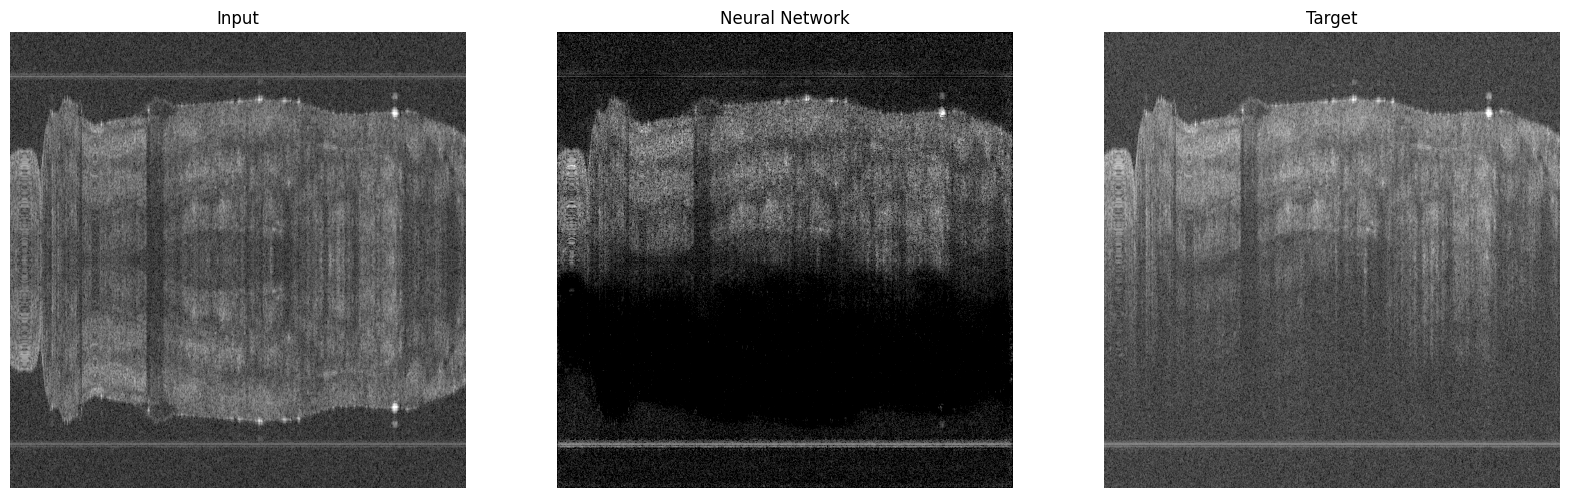

In [15]:
vmax = 120
vmin = 60
bscan = 0
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(20,15))
axs[0].imshow(dbscale(tomcc[:,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(dbscale(tomPredictFullScale[:,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[1].axis('off')
axs[1].set_title('Neural Network')
axs[2].imshow(dbscale(tom[:,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[2].axis('off')
axs[2].set_title('Target')